In [2]:
import numpy as np
import cv2
import pims
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

/home/neo/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [8]:
#resolution and labels

# TESLA resolution
W = 1280
H = 960

# COMMA.AI resolution
#W = 1164
#H = 874

# low resolutions (to avoid low memory problems)
#W = 640
#H = 480

# this was used for slam
#W = 1920//2
#H = 1080//2

LABEL_DICT = {0: "no crossroad", 1: "crossroad"}

In [4]:
# Get data from files
def get_data(video_path, log_path):
  with open(log_path, "r") as log_file:
    labels = log_file.read().split("\n")[:-1]
    log_file.close()
  print("Log file read")

  # TODO: check nvidia's nvvl [ https://github.com/NVIDIA/nvvl ] [ https://github.com/mitmul/pynvvl ]
  # make a Video Object instead of loading all frames in memory
  # to access frames just do: frame = frames[n]
  print("Extracting frames ...")
  frames = pims.Video(video_path, format="mp4")
  print("Done extracting frames")

  return frames, np.array(labels).astype(np.int)

video_path = "/home/neo/Dev/university/OpenCRD/data/videos/with_crossroads/city_1.mp4"# CHANGE THIS
log_path = video_path[:-4] + ".txt"

frames, labels = get_data(video_path, log_path)

Log file read
Extracting frames ...
Done extracting frames


<ipython-input-4-cfdac89bc13b>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return frames, np.array(labels).astype(np.int)


In [5]:
print(frames)
print(labels)

<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: /home/neo/Dev/university/OpenCRD/data/videos/with_crossroads/city_1.mp4
Duration: 35.252 seconds
Frame rate: 59.940 fps
Length: 2113 frames
Frame Shape: (1440, 2562, 3)

[0 0 0 ... 0 0 0]


crossroad


/home/neo/.local/lib/python3.8/site-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


Frame([[[153, 152, 155],
        [154, 153, 156],
        [153, 152, 155],
        ...,
        [ 27,  25,  23],
        [ 27,  25,  23],
        [ 27,  25,  23]],

       [[153, 152, 155],
        [153, 152, 155],
        [153, 152, 155],
        ...,
        [ 10,   8,   6],
        [ 10,   8,   6],
        [ 10,   8,   6]],

       [[153, 152, 155],
        [153, 152, 155],
        [153, 152, 155],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]],

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]],

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]]], dtype=uint8)
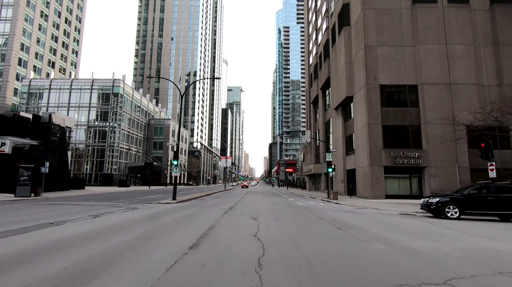

In [6]:
frames.frame_shape
print(LABEL_DICT[labels[800]])
frames[800]

In [10]:
img = cv2.resize(cv2.cvtColor(frames[800], cv2.COLOR_BGR2RGB), (640,480))
print(img)
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[155 152 153]
  [158 151 151]
  [159 147 147]
  ...
  [ 11  13  15]
  [  6   8  10]
  [  6   8  10]]

 [[155 152 153]
  [161 155 153]
  [150 140 138]
  ...
  [  4   6   8]
  [  9  11  13]
  [  9  11  13]]

 [[152 149 150]
  [157 150 150]
  [130 120 118]
  ...
  [  3   5   7]
  [  0   2   4]
  [  0   2   4]]

 ...

 [[122 120 125]
  [122 120 125]
  [123 121 126]
  ...
  [125 124 126]
  [125 124 126]
  [125 124 127]]

 [[122 120 125]
  [122 120 125]
  [123 121 126]
  ...
  [125 124 126]
  [125 124 126]
  [125 124 127]]

 [[122 120 125]
  [122 120 125]
  [123 121 126]
  ...
  [125 124 126]
  [125 124 126]
  [125 124 127]]]


In [10]:
X_train = cv2.resize(cv2.cvtColor(frames[800], cv2.COLOR_BGR2RGB), (W,H))
X_train.shape

(960, 1280, 3)

In [12]:
Y_train = labels[800]
Y_train

1

In [19]:
X = torch.tensor(X_train)
X.shape

torch.Size([960, 1280, 3])

In [20]:
Y = torch.tensor(Y_train)
Y

tensor(1)

In [10]:
BS = 128
samp = np.random.randint(0, len(frames), size=(BS))

# TODO: this will be different in the final product
X_train = []
cnt = 0
# TODO: this is too slow, maybe i can speed it up
for idx in samp:
    print("Processing %d idx: %d" % (cnt, idx) )
    X_train.append(cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H)))
    cnt += 1
X_train = np.array(X_train)
# TODO: check if making X_train = [] will free some memory for the next training iteration (or else we are gonna have a huge memory problem)

Processing 0 idx: 527
Processing 1 idx: 1641
Processing 2 idx: 460
Processing 3 idx: 1507
Processing 4 idx: 1887
Processing 5 idx: 612
Processing 6 idx: 1160
Processing 7 idx: 746
Processing 8 idx: 422
Processing 9 idx: 1339
Processing 10 idx: 973
Processing 11 idx: 764
Processing 12 idx: 1890
Processing 13 idx: 554
Processing 14 idx: 1070
Processing 15 idx: 1410
Processing 16 idx: 1720
Processing 17 idx: 1422
Processing 18 idx: 1957
Processing 19 idx: 1404
Processing 20 idx: 713
Processing 21 idx: 750
Processing 22 idx: 1842
Processing 23 idx: 999
Processing 24 idx: 218
Processing 25 idx: 430
Processing 26 idx: 1220
Processing 27 idx: 1753
Processing 28 idx: 764
Processing 29 idx: 181
Processing 30 idx: 794
Processing 31 idx: 2029
Processing 32 idx: 1209
Processing 33 idx: 1975
Processing 34 idx: 610
Processing 35 idx: 507
Processing 36 idx: 911
Processing 37 idx: 1598
Processing 38 idx: 1373
Processing 39 idx: 25
Processing 40 idx: 1526
Processing 41 idx: 2014
Processing 42 idx: 262


In [11]:
print(X_train)
X_train.shape

[[[[182 182 166]
   [182 182 166]
   [183 183 167]
   ...
   [  3   3   3]
   [ 39  41  43]
   [ 96  99  99]]

  [[182 182 166]
   [182 182 166]
   [183 183 167]
   ...
   [ 41  42  44]
   [ 84  86  88]
   [ 81  84  84]]

  [[182 182 166]
   [182 182 166]
   [183 183 167]
   ...
   [ 97  99 101]
   [ 55  57  58]
   [  9  12  12]]

  ...

  [[105  98 104]
   [105  98 104]
   [105  98 104]
   ...
   [142 140 145]
   [142 140 145]
   [142 140 145]]

  [[105  98 104]
   [105  98 104]
   [105  98 104]
   ...
   [142 140 145]
   [142 140 145]
   [142 140 145]]

  [[105  98 104]
   [105  98 104]
   [105  98 104]
   ...
   [142 140 145]
   [142 140 145]
   [142 140 145]]]


 [[[111 100  89]
   [108  97  86]
   [100  89  78]
   ...
   [146 149 131]
   [146 149 131]
   [145 148 130]]

  [[120 109  98]
   [116 105  94]
   [109  98  87]
   ...
   [161 165 150]
   [160 164 149]
   [159 163 148]]

  [[117 106  95]
   [115 104  93]
   [109  98  87]
   ...
   [161 165 152]
   [164 169 156]
   [165 169

(128, 960, 1280, 3)

In [12]:
# NOTE: the program takes more than 3GB of RAM so far
X = torch.tensor(X_train).float()
print(X.shape)
X

torch.Size([128, 960, 1280, 3])


tensor([[[[182., 182., 166.],
          [182., 182., 166.],
          [183., 183., 167.],
          ...,
          [  3.,   3.,   3.],
          [ 39.,  41.,  43.],
          [ 96.,  99.,  99.]],

         [[182., 182., 166.],
          [182., 182., 166.],
          [183., 183., 167.],
          ...,
          [ 41.,  42.,  44.],
          [ 84.,  86.,  88.],
          [ 81.,  84.,  84.]],

         [[182., 182., 166.],
          [182., 182., 166.],
          [183., 183., 167.],
          ...,
          [ 97.,  99., 101.],
          [ 55.,  57.,  58.],
          [  9.,  12.,  12.]],

         ...,

         [[105.,  98., 104.],
          [105.,  98., 104.],
          [105.,  98., 104.],
          ...,
          [142., 140., 145.],
          [142., 140., 145.],
          [142., 140., 145.]],

         [[105.,  98., 104.],
          [105.,  98., 104.],
          [105.,  98., 104.],
          ...,
          [142., 140., 145.],
          [142., 140., 145.],
          [142., 140., 145.]],



In [13]:
Y_train = labels
Y = torch.tensor(Y_train[samp]).long()
print(Y.shape)
Y

torch.Size([128])


tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0])

In [21]:
# test if we get more memory if we reset X_train
X_train = []
# we do, but the tensor holds more than 1GB still
X = []
# and the above does not improve on memory (maybe it doesn't matter since it gets reassigned, need to benchmark)
# so 4GB of RAM is recommended just for this process (I have 12GB and it gets 70% usage)